In [10]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
sns.set()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Stampa il dispositivo in uso
print("Stai utilizzando il dispositivo:", device)

Stai utilizzando il dispositivo: cpu


In [11]:
import sys
import platform
import torch
import pandas as pd
import sklearn as sk 

has_gpu = torch.cuda.is_available() 
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

print("Stai utilizzando il dispositivo:", device)

Python Platform: macOS-14.2.1-arm64-arm-64bit
PyTorch Version: 2.2.0

Python 3.10.1 (v3.10.1:2cd268a3a9, Dec  6 2021, 14:28:59) [Clang 13.0.0 (clang-1300.0.29.3)]
Pandas 1.3.4
Scikit-Learn 1.4.0
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps
Stai utilizzando il dispositivo: mps


In [12]:
from PIL import Image

In [13]:
img = Image.open('/Users/roberto/Desktop/codici DL/target_spaziali/train/target_1/1_target117.png')

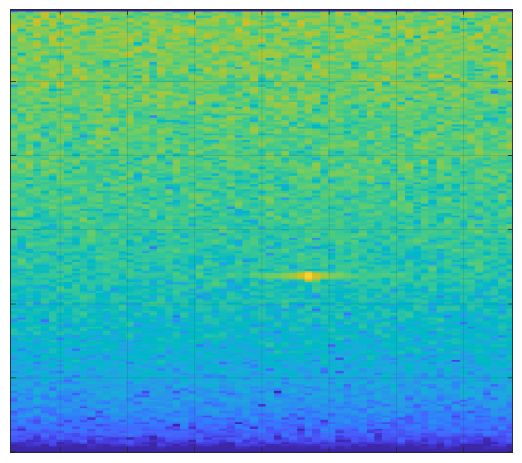

In [14]:
t = transforms.ToTensor()(img)

t = t[:,49:584, 102:708]
plt.imshow(t.permute(1,2,0))
plt.axis('off')
plt.tight_layout()

In [15]:
t

tensor([[[0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490],
         [0.1490, 0.2392, 0.2392,  ..., 0.2392, 0.2392, 0.1490],
         [0.1490, 0.2392, 0.2392,  ..., 0.2392, 0.2392, 0.1490],
         ...,
         [0.1490, 0.2392, 0.2392,  ..., 0.2392, 0.2392, 0.1490],
         [0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490],
         [0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490]],

        [[0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490],
         [0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490],
         [0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490],
         ...,
         [0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490],
         [0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490],
         [0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490]],

        [[0.1490, 0.1490, 0.1490,  ..., 0.1490, 0.1490, 0.1490],
         [0.1490, 0.6588, 0.6588,  ..., 0.6588, 0.6588, 0.1490],
         [0.1490, 0.6588, 0.6588,  ..., 0.6588, 0.6588, 0.

In [16]:
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image

class RemoveContoursTransform:
    def __init__(self, blur_value=5):
        self.blur_value = blur_value

    def __call__(self, img):
        # Converti l'immagine PIL in un array NumPy
        img_np = np.array(img)

        # Applica la sfocatura all'immagine
        blurred_img_np = cv2.GaussianBlur(img_np, (self.blur_value, self.blur_value), 0)

        # Converti l'immagine NumPy nuovamente in un oggetto PIL e restituiscila
        return Image.fromarray(blurred_img_np)


In [17]:
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, WeightedRandomSampler
import numpy as np
from torchvision import datasets

def get_train_valid_loader(data_dir, batch_size, augment, random_seed, valid_size=0.1, shuffle=True):
    # Normalizzazione delle immagini
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

    # Trasformazioni base
    base_transforms = [transforms.Resize((227, 227)), transforms.ToTensor(), normalize]

    # Trasformazioni di augmentazione
    augmentation_transforms = [transforms.RandomHorizontalFlip(), transforms.RandomRotation(10)]

    # Trasformazioni per il set di addestramento
    train_transform = transforms.Compose(augmentation_transforms + base_transforms if augment else base_transforms)

    # Trasformazioni per il set di convalida
    valid_transform = transforms.Compose(base_transforms)

    # Carica i dataset
    train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=train_transform)
    valid_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=valid_transform)  

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=4)

    return train_loader, valid_loader

# Funzione get_test_loader e show_images rimangono invariate

# Esempio di utilizzo delle funzioni
train_loader, test_loader = get_train_valid_loader(data_dir='/Users/roberto/Desktop/codici DL/target_spaziali', batch_size=64, augment=True, random_seed=1)


# Visualizza alcune immagini
#show_images(train_loader)


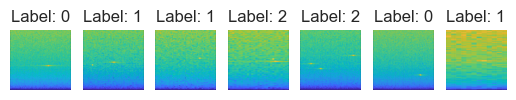

In [19]:

# Funzione per ottenere i loader di addestramento e convalida
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,   ###percentuale del validation set , io ho train e test e non validation , dunque sto dicendo :
                           shuffle=True):    ###prendi il 10% del train e usalo per fare la validation !
    # Normalizzazione delle immagini
    normalize = transforms.Normalize(     ### valori medi per i coliri rgb sepmre
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    crop = transforms.Lambda(lambda x: x[:,49:584, 102:708])
    # Trasformazioni per il set di convalida
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        crop,
        transforms.Resize((227, 227))
        #normalize,
    ])

    # Trasformazioni per il set di addestramento

    train_transform = transforms.Compose([
        transforms.ColorJitter(0.01, 0.01, 0.01, 0.01),    ###brigtnes,  contrast,saturation ,hue
        transforms.ToTensor(),
        crop,
        transforms.Resize((227, 227))
        #normalize,
    ])


    # Carica il dataset "TargetSpaziali" per addestramento e convalida
    train_dataset = datasets.ImageFolder(
        root=data_dir + '/train',  # Cartella del set di addestramento
        transform=train_transform,
    )

    valid_dataset = datasets.ImageFolder(
        root=data_dir + '/train',  # Utilizza la stessa cartella del set di addestramento per la convalida
        transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    # Se richiesto, mescola gli indici
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    # Suddivide gli indici per ottenere gli indici per addestramento e convalida
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Crea i DataLoader per addestramento e convalida
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=0)


    return (train_loader, valid_loader)


# Funzione per ottenere il DataLoader per il set di test
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):    
    # Normalizzazione delle immagini
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    #Uso una funzione lambda per tagliare l'immagine alle dimensioni specificate, mantenendo tutti i suou canali (RGB)

    crop = transforms.Lambda(lambda x: x[:,49:584, 102:708])  


    # Trasformazioni per il set di test
    transform = transforms.Compose([
        transforms.ToTensor(),
        crop,
        transforms.Resize((227, 227))
        #normalize,
    ])

    # Carica il dataset "TargetSpaziali" per il test
    test_dataset = datasets.ImageFolder(
        root=data_dir + '/test',  # Cartella del set di test
        transform=transform,
    )

    # Crea il DataLoader per il set di test
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,num_workers=0
    )

    return test_loader


# Esempio di utilizzo delle funzioni per ottenere i DataLoader
# dogsAndCats dataset
train_loader, valid_loader = get_train_valid_loader(
    data_dir='/Users/roberto/Desktop/codici DL/target_spaziali', batch_size=64,
    augment=True, random_seed=1
)

test_loader = get_test_loader(
    data_dir='/Users/roberto/Desktop/codici DL/target_spaziali', batch_size=64
)

# Funzione per visualizzare alcune immagini dal DataLoader
def show_images(loader, num_images=7):
    # Ottieni un iteratore dal DataLoader
    data_iter = iter(loader)

    # Estrai il prossimo batch dal DataLoader
    images, labels = next(data_iter)

    # Visualizza le immagini e le relative etichette
    for i in range(num_images):
        image = images[i].numpy().transpose((1, 2, 0))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

# Visualizza alcune immagini dal DataLoader di addestramento
show_images(train_loader)


ResNet18

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definizione del blocco base della ResNet
class BasicBlock(nn.Module):
    # expansion è un parametro che scala la dimensione dell'output del blocco
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        
        #andiamo a creare il blocco base resNET
        
        # Primo strato convoluzionale
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)  # Batch normalization dopo il primo strato
        # Secondo strato convoluzionale
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)  # Batch normalization dopo il secondo strato

        # Connessione shortcut per gestire gli input se c'è un cambio di dimensione
        self.shortcut = nn.Sequential()
        #Se la condizione è verificata, viene creata una connessione shortcut tramite un modulo Sequential
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # Applicazione ReLU dopo il primo strato convoluzionale
        out = self.bn2(self.conv2(out))  # Applicazione Batch Normalization dopo il secondo strato convoluzionale
        out += self.shortcut(x)  # Aggiunta della shortcut connection
        out = F.relu(out)  # Applicazione ReLU dopo l'aggiunta della shortcut connection
        return out

# Definizione dell'architettura ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        # Primo strato convoluzionale seguito da Batch Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Definizione dei vari livelli della rete utilizzando i blocchi base
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Global Average Pooling (GAP) per ridurre le dimensioni spaziali
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    # Metodo per creare un singolo livello della rete usando il blocco base
    def _make_layer(self, block, planes, num_blocks, stride):
    # Creazione di una lista di stride per ogni blocco nel livello
        strides = [stride] + [1] * (num_blocks - 1)
    
    # Lista che conterrà i blocchi del livello
        layers = []

    # Ciclo attraverso ogni stride e crea un blocco per ciascuno
        for stride in strides:
        # Aggiungi il blocco alla lista 'layers'
            layers.append(block(self.in_planes, planes, stride))
        
        # Aggiorna il numero di canali 'in_planes' per il prossimo blocco
            self.in_planes = planes * block.expansion

    # Restituisci i blocchi come un livello sequenziale
        return nn.Sequential(*layers)


    # Passaggio in avanti attraverso la rete
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        # Primo strato convoluzionale seguito da Batch Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Definizione dei vari livelli della rete utilizzando i blocchi base
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Global Average Pooling (GAP) per ridurre le dimensioni spaziali
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    # Metodo per creare un singolo livello della rete usando il blocco base
    def _make_layer(self, block, planes, num_blocks, stride):
    # Creazione di una lista di stride per ogni blocco nel livello
        strides = [stride] + [1] * (num_blocks - 1)
    
    # Lista che conterrà i blocchi del livello
        layers = []

    # Ciclo attraverso ogni stride e crea un blocco per ciascuno
        for stride in strides:
        # Aggiungi il blocco alla lista 'layers'
            layers.append(block(self.in_planes, planes, stride))
        
        # Aggiorna il numero di canali 'in_planes' per il prossimo blocco
            self.in_planes = planes * block.expansion

    # Restituisci i blocchi come un livello sequenziale
        return nn.Sequential(*layers)


    # Passaggio in avanti attraverso la rete
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out






In [22]:
# Numero di classi nel problema di classificazione
num_classes = 3

# Numero di epoche per l'addestramento
num_epochs = 35

# Dimensione del batch durante l'addestramento
batch_size = 64

# Tasso di apprendimento per l'ottimizzatore
learning_rate = 0.001   #0.1-0.001

# Creazione di un'istanza del modello e spostamento del modello sulla GPU (se disponibile)
model = ResNet18(num_classes).to(device)

# Definizione della funzione di perdita (cross-entropy) e dell'ottimizzatore (ADAM)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)     #### 0.005 a diminuire , aggiungi zeri....

# Numero totale di passaggi (batches) nell'addestramento, determinato dalla lunghezza del DataLoader di addestramento
total_step = len(train_loader)


In [24]:
# Ciclo sul numero di epoche specificato
for epoch in range(num_epochs):
    total = 0
    correct = 0
    # Ciclo su ogni batch nel DataLoader di addestramento
    for i, (images, labels) in enumerate(train_loader):  
        # Sposta i tensori sul dispositivo configurato (GPU o CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calcola la perdita utilizzando la funzione di perdita definita in precedenza (CrossEntropyLoss)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        
        # Backward pass e ottimizzazione dei pesi
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Stampa l'informazione sull'andamento dell'addestramento (epoca corrente, passaggio corrente, perdita corrente)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Acc: {}%' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), round(100*correct/total,2)))
            
    # Validazione del modello
    with torch.no_grad():
        correct = 0
        total = 0
        # Ciclo su ogni batch nel DataLoader di convalida
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            # Calcola le predizioni e la precisione del modello sulla convalida
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Libera memoria rimuovendo i tensori temporanei
            del images, labels, outputs
    
        # Stampa l'accuratezza del modello sulla convalida
        print('Accuracy of the network on the {} validation images: {} %'.format(len(valid_loader.dataset), round(100 * correct / total,2)))
 

Epoch [1/35], Step [7/7], Loss: 1.0844, Train Acc: 46.76%
Accuracy of the network on the 480 validation images: 41.67 %
Epoch [2/35], Step [7/7], Loss: 0.8957, Train Acc: 48.84%
Accuracy of the network on the 480 validation images: 50.0 %
Epoch [3/35], Step [7/7], Loss: 1.0079, Train Acc: 46.76%
Accuracy of the network on the 480 validation images: 45.83 %
Epoch [4/35], Step [7/7], Loss: 1.0533, Train Acc: 47.22%
Accuracy of the network on the 480 validation images: 43.75 %
Epoch [5/35], Step [7/7], Loss: 0.9519, Train Acc: 47.45%
Accuracy of the network on the 480 validation images: 52.08 %
Epoch [6/35], Step [7/7], Loss: 0.9665, Train Acc: 47.45%
Accuracy of the network on the 480 validation images: 47.92 %
Epoch [7/35], Step [7/7], Loss: 0.9257, Train Acc: 47.92%
Accuracy of the network on the 480 validation images: 52.08 %
Epoch [8/35], Step [7/7], Loss: 1.0660, Train Acc: 49.31%
Accuracy of the network on the 480 validation images: 45.83 %
Epoch [9/35], Step [7/7], Loss: 0.9360, T

Precision on the 120 test images: 0.48
Recall on the 120 test images: 0.49
Accuracy on the 120 test images: 0.49


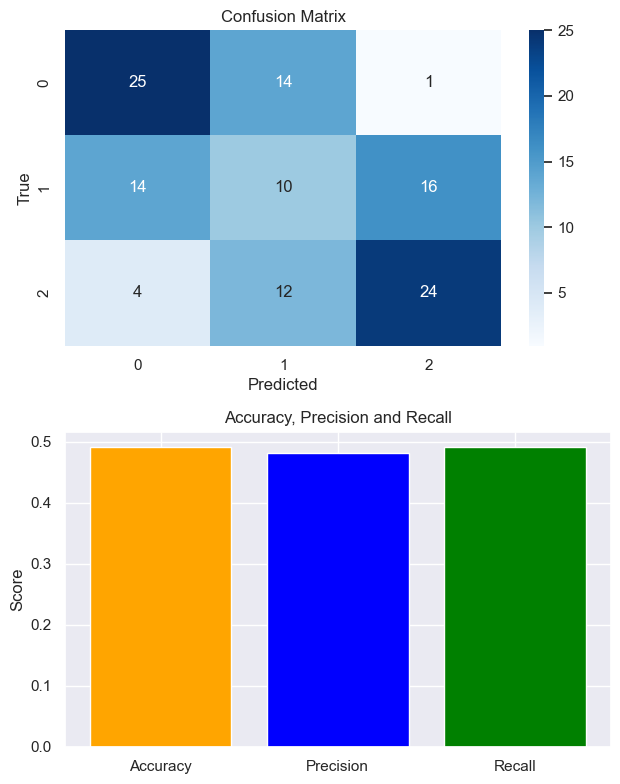

In [25]:


# Test del modello su dati di test
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    # Ciclo su ogni batch nel DataLoader di test
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # Ottieni le predizioni e calcola le metriche di valutazione
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Libera memoria rimuovendo i tensori temporanei
        del images, labels, outputs

    # Calcola precision, recall e accuracy
    test_precision = precision_score(all_labels, all_predicted, average='weighted')
    test_recall = recall_score(all_labels, all_predicted, average='weighted')
    test_accuracy = accuracy_score(all_labels, all_predicted)
    
    # Stampa le metriche di valutazione
    print('Precision on the {} test images: {:.2f}'.format(total, test_precision))
    print('Recall on the {} test images: {:.2f}'.format(total, test_recall))
    print('Accuracy on the {} test images: {:.2f}'.format(total, test_accuracy))

    # Calcola la confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    
    # Visualizza la confusion matrix
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(range(3)), yticklabels=list(range(3)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Visualizza gli istogrammi di precision e recall
    plt.subplot(2, 2, 3)
    plt.bar(['Accuracy', 'Precision', 'Recall'], [test_accuracy, test_precision, test_recall], color=['orange', 'blue', 'green'])
    plt.ylabel('Score')
    plt.title('Accuracy, Precision and Recall')

    # Aggiusta la disposizione dei subplot
    plt.tight_layout()
    
    # Mostra i grafici
    plt.show()


ora provo una rete piu semplice con meno strati : 


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool2d(2)
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        # Assuming the input dimensions are (3, 32, 32), the output dimensions after convolutions are (128, 32, 32)
        # This assumes no pooling layers are used. If pooling is used, dimensions will change accordingly.
        self.fc1 = nn.Linear(64 * 25 * 25, 128)  # First linear layer
        self.fc2 = nn.Linear(128, num_classes)    # Second linear layer

    def forward(self, x):
        # Apply first convolution with relu
        x = self.pool(F.relu(self.conv1(x)))
        
        # Apply second convolution with relu
        x = self.pool(F.relu(self.conv2(x)))
        
        # Apply third convolution with relu
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output for the linear layer
        x = x.view(x.size(0), -1)

        x = F.dropout(x, 0.25)   ####0.3 e via abbasando
        
        # Apply the first linear layer with relu
        x = F.relu(self.fc1(x))
        
        # Apply the second linear layer
        x = self.fc2(x)
        
        return x

In [9]:
# Numero di classi nel problema di classificazione
num_classes = 3

# Numero di epoche per l'addestramento
num_epochs = 50

# Dimensione del batch durante l'addestramento
batch_size = 64

# Tasso di apprendimento per l'ottimizzatore
learning_rate = 0.001   #0.1-0.001

# Creazione di un'istanza del modello e spostamento del modello sulla GPU (se disponibile)
model = CustomCNN(num_classes).to(device)

# Definizione della funzione di perdita (cross-entropy) e dell'ottimizzatore (ADAM)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)     #### 0.005 a diminuire , aggiungi zeri....

# Numero totale di passaggi (batches) nell'addestramento, determinato dalla lunghezza del DataLoader di addestramento
total_step = len(train_loader)


In [10]:
# Ciclo sul numero di epoche specificato
for epoch in range(num_epochs):
    total = 0
    correct = 0
    # Ciclo su ogni batch nel DataLoader di addestramento
    for i, (images, labels) in enumerate(train_loader):  
        # Sposta i tensori sul dispositivo configurato (GPU o CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calcola la perdita utilizzando la funzione di perdita definita in precedenza (CrossEntropyLoss)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        
        # Backward pass e ottimizzazione dei pesi
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Stampa l'informazione sull'andamento dell'addestramento (epoca corrente, passaggio corrente, perdita corrente)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Acc: {}%' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), round(100*correct/total,2)))
            
    # Validazione del modello
    with torch.no_grad():
        correct = 0
        total = 0
        # Ciclo su ogni batch nel DataLoader di convalida
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            # Calcola le predizioni e la precisione del modello sulla convalida
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Libera memoria rimuovendo i tensori temporanei
            del images, labels, outputs
    
        # Stampa l'accuratezza del modello sulla convalida
        print('Accuracy of the network on the {} validation images: {} %'.format(len(valid_loader.dataset), round(100 * correct / total,2)))
 

Epoch [1/50], Step [7/7], Loss: 1.0594, Train Acc: 37.5%
Accuracy of the network on the 480 validation images: 43.75 %
Epoch [2/50], Step [7/7], Loss: 1.0503, Train Acc: 42.82%
Accuracy of the network on the 480 validation images: 39.58 %
Epoch [3/50], Step [7/7], Loss: 1.0058, Train Acc: 44.21%
Accuracy of the network on the 480 validation images: 41.67 %
Epoch [4/50], Step [7/7], Loss: 1.0888, Train Acc: 43.29%
Accuracy of the network on the 480 validation images: 43.75 %
Epoch [5/50], Step [7/7], Loss: 1.0890, Train Acc: 44.91%
Accuracy of the network on the 480 validation images: 43.75 %
Epoch [6/50], Step [7/7], Loss: 0.9780, Train Acc: 42.13%
Accuracy of the network on the 480 validation images: 43.75 %
Epoch [7/50], Step [7/7], Loss: 1.0290, Train Acc: 44.68%
Accuracy of the network on the 480 validation images: 41.67 %
Epoch [8/50], Step [7/7], Loss: 1.0264, Train Acc: 43.52%
Accuracy of the network on the 480 validation images: 47.92 %
Epoch [9/50], Step [7/7], Loss: 1.0874, T

Precision on the 120 test images: 0.50
Recall on the 120 test images: 0.47
Accuracy on the 120 test images: 0.47


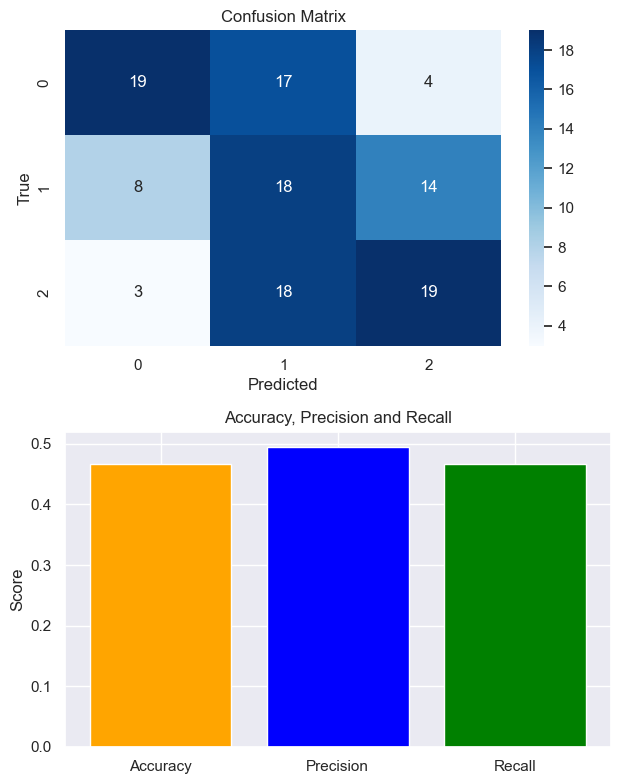

In [11]:


# Test del modello su dati di test
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    # Ciclo su ogni batch nel DataLoader di test
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # Ottieni le predizioni e calcola le metriche di valutazione
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Libera memoria rimuovendo i tensori temporanei
        del images, labels, outputs

    # Calcola precision, recall e accuracy
    test_precision = precision_score(all_labels, all_predicted, average='weighted')
    test_recall = recall_score(all_labels, all_predicted, average='weighted')
    test_accuracy = accuracy_score(all_labels, all_predicted)
    
    # Stampa le metriche di valutazione
    print('Precision on the {} test images: {:.2f}'.format(total, test_precision))
    print('Recall on the {} test images: {:.2f}'.format(total, test_recall))
    print('Accuracy on the {} test images: {:.2f}'.format(total, test_accuracy))

    # Calcola la confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    
    # Visualizza la confusion matrix
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(range(3)), yticklabels=list(range(3)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Visualizza gli istogrammi di precision e recall
    plt.subplot(2, 2, 3)
    plt.bar(['Accuracy', 'Precision', 'Recall'], [test_accuracy, test_precision, test_recall], color=['orange', 'blue', 'green'])
    plt.ylabel('Score')
    plt.title('Accuracy, Precision and Recall')

    # Aggiusta la disposizione dei subplot
    plt.tight_layout()
    
    # Mostra i grafici
    plt.show()


ORA PROVO CON ALEXNET


In [30]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [31]:
# Numero di classi nel problema di classificazione
num_classes = 3

# Numero di epoche per l'addestramento
num_epochs = 50

# Dimensione del batch durante l'addestramento
batch_size = 64

# Tasso di apprendimento per l'ottimizzatore
learning_rate = 0.001   #0.1-0.001

# Creazione di un'istanza del modello e spostamento del modello sulla GPU (se disponibile)
model = AlexNet(num_classes).to(device)

# Definizione della funzione di perdita (cross-entropy) e dell'ottimizzatore (ADAM)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)     #### 0.005 a diminuire , aggiungi zeri....

# Numero totale di passaggi (batches) nell'addestramento, determinato dalla lunghezza del DataLoader di addestramento
total_step = len(train_loader)


In [32]:
# Ciclo sul numero di epoche specificato
for epoch in range(num_epochs):
    total = 0
    correct = 0
    # Ciclo su ogni batch nel DataLoader di addestramento
    for i, (images, labels) in enumerate(train_loader):  
        # Sposta i tensori sul dispositivo configurato (GPU o CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calcola la perdita utilizzando la funzione di perdita definita in precedenza (CrossEntropyLoss)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        
        # Backward pass e ottimizzazione dei pesi
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Stampa l'informazione sull'andamento dell'addestramento (epoca corrente, passaggio corrente, perdita corrente)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Acc: {}%' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), round(100*correct/total,2)))
            
    # Validazione del modello
    with torch.no_grad():
        correct = 0
        total = 0
        # Ciclo su ogni batch nel DataLoader di convalida
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            # Calcola le predizioni e la precisione del modello sulla convalida
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Libera memoria rimuovendo i tensori temporanei
            del images, labels, outputs
    
        # Stampa l'accuratezza del modello sulla convalida
        print('Accuracy of the network on the {} validation images: {} %'.format(len(valid_loader.dataset), round(100 * correct / total,2)))
 

Epoch [1/50], Step [7/7], Loss: 8.0142, Train Acc: 30.32%
Accuracy of the network on the 480 validation images: 25.0 %
Epoch [2/50], Step [7/7], Loss: 1.1348, Train Acc: 33.56%
Accuracy of the network on the 480 validation images: 45.83 %
Epoch [3/50], Step [7/7], Loss: 1.0822, Train Acc: 37.73%
Accuracy of the network on the 480 validation images: 50.0 %
Epoch [4/50], Step [7/7], Loss: 1.1134, Train Acc: 40.97%
Accuracy of the network on the 480 validation images: 39.58 %
Epoch [5/50], Step [7/7], Loss: 1.0474, Train Acc: 34.03%
Accuracy of the network on the 480 validation images: 41.67 %
Epoch [6/50], Step [7/7], Loss: 0.9822, Train Acc: 38.43%
Accuracy of the network on the 480 validation images: 39.58 %
Epoch [7/50], Step [7/7], Loss: 1.0273, Train Acc: 40.05%
Accuracy of the network on the 480 validation images: 45.83 %
Epoch [8/50], Step [7/7], Loss: 1.0169, Train Acc: 42.36%
Accuracy of the network on the 480 validation images: 47.92 %
Epoch [9/50], Step [7/7], Loss: 1.1916, Tr

Precision on the 120 test images: 0.37
Recall on the 120 test images: 0.44
Accuracy on the 120 test images: 0.44


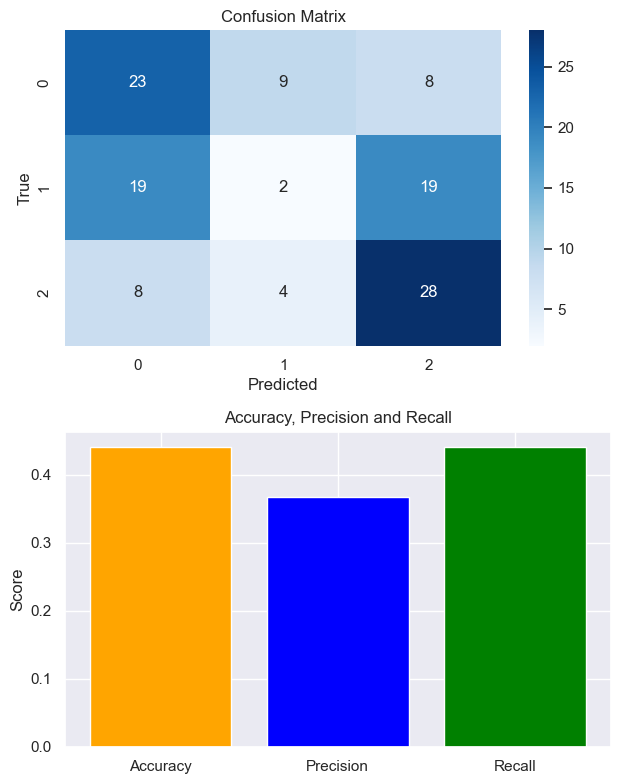

In [33]:


# Test del modello su dati di test
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    # Ciclo su ogni batch nel DataLoader di test
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # Ottieni le predizioni e calcola le metriche di valutazione
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Libera memoria rimuovendo i tensori temporanei
        del images, labels, outputs

    # Calcola precision, recall e accuracy
    test_precision = precision_score(all_labels, all_predicted, average='weighted')
    test_recall = recall_score(all_labels, all_predicted, average='weighted')
    test_accuracy = accuracy_score(all_labels, all_predicted)
    
    # Stampa le metriche di valutazione
    print('Precision on the {} test images: {:.2f}'.format(total, test_precision))
    print('Recall on the {} test images: {:.2f}'.format(total, test_recall))
    print('Accuracy on the {} test images: {:.2f}'.format(total, test_accuracy))

    # Calcola la confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    
    # Visualizza la confusion matrix
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(range(3)), yticklabels=list(range(3)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Visualizza gli istogrammi di precision e recall
    plt.subplot(2, 2, 3)
    plt.bar(['Accuracy', 'Precision', 'Recall'], [test_accuracy, test_precision, test_recall], color=['orange', 'blue', 'green'])
    plt.ylabel('Score')
    plt.title('Accuracy, Precision and Recall')

    # Aggiusta la disposizione dei subplot
    plt.tight_layout()
    
    # Mostra i grafici
    plt.show()
